# DTree Regressor Demonstration

In this tutorial we will demonstrate how to use the `DecisionTreeRegressor` class in `scikit-learn` to perform classifications predictions. 


## 1.0 Setup
Import modules


In [8]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


np.random.seed(1)

## 2.0 Load data
Load data (it's already cleaned and preprocessed)


In [9]:
# Uncomment the following snippet of code to debug problems with finding the .csv file path
# This snippet of code will exit the program and print the current working directory.
#import os
#print(os.getcwd())

In [10]:
X_train = pd.read_csv('./data/airbnb_train_X_price.csv') 
y_train = pd.read_csv('./data/airbnb_train_y_price.csv') 
X_test = pd.read_csv('./data/airbnb_test_X_price.csv') 
y_test = pd.read_csv('./data/airbnb_test_y_price.csv') 

## 3.0 Model the data

Conduct an initial random search across a wide range of possible parameters.

> NOTE: Notice that the score measure is negated. This is because the `GridSearchCV` class expects a score function that is greater for better models. This works well when we are looking to maximize a score, such as accuracy. However, in this case we are looking to minimize the mean squared error, so we need to negate the score. See here for more details: https://scikit-learn.org/stable/modules/model_evaluation.html

In [11]:
score_measure = "neg_mean_squared_error"
kfolds = 5

param_grid = {
    'min_samples_split': np.arange(2,200),  
    'min_samples_leaf': np.arange(1,200),
    'min_impurity_decrease': np.arange(0.0001, 0.01, 0.0005),
    'max_leaf_nodes': np.arange(5, 200), 
    'max_depth': np.arange(1,50), 
    'criterion': ['squared_error', 'poisson', 'absolute_error', 'friedman_mse'],
}

dtree = DecisionTreeRegressor()
rand_search = RandomizedSearchCV(estimator = dtree, param_distributions=param_grid, cv=kfolds, n_iter=500,
                           scoring=score_measure, verbose=1, n_jobs=-1,  # n_jobs=-1 will utilize all available CPUs 
                           return_train_score=True)

_ = rand_search.fit(X_train, y_train)

print(f"The best {score_measure} score is {rand_search.best_score_}")
print(f"... with parameters: {rand_search.best_params_}")

bestRecallTree = rand_search.best_estimator_

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
The best neg_mean_squared_error score is -4778.108287183606
... with parameters: {'min_samples_split': 29, 'min_samples_leaf': 18, 'min_impurity_decrease': 0.0036, 'max_leaf_nodes': 78, 'max_depth': 10, 'criterion': 'poisson'}


Conduct an exhaustive search across a smaller range of parameters around the parameters found in the initial random search.

In [12]:
score_measure = "neg_mean_squared_error"
kfolds = 5
min_samples_split = rand_search.best_params_['min_samples_split']
min_samples_leaf = rand_search.best_params_['min_samples_leaf']
min_impurity_decrease = rand_search.best_params_['min_impurity_decrease']
max_leaf_nodes = rand_search.best_params_['max_leaf_nodes']
max_depth = rand_search.best_params_['max_depth']
criterion = rand_search.best_params_['criterion']

param_grid = {
    'min_samples_split': np.arange(min_samples_split-2,min_samples_split+2),  
    'min_samples_leaf': np.arange(min_samples_leaf-2,min_samples_leaf+2),
    'min_impurity_decrease': np.arange(min_impurity_decrease-0.0001, min_impurity_decrease+0.0001, 0.00005),
    'max_leaf_nodes': np.arange(max_leaf_nodes-2,max_leaf_nodes+2), 
    'max_depth': np.arange(max_depth-2,max_depth+2), 
    'criterion': [criterion]
}

dtree = DecisionTreeRegressor()
grid_search = GridSearchCV(estimator = dtree, param_grid=param_grid, cv=kfolds, 
                           scoring=score_measure, verbose=1, n_jobs=-1,  # n_jobs=-1 will utilize all available CPUs 
                           return_train_score=True)

_ = grid_search.fit(X_train, y_train)

print(f"The best {score_measure} score is {grid_search.best_score_}")
print(f"... with parameters: {grid_search.best_params_}")

bestRecallTree = grid_search.best_estimator_

Fitting 5 folds for each of 1024 candidates, totalling 5120 fits
The best neg_mean_squared_error score is -4775.574245083685
... with parameters: {'criterion': 'poisson', 'max_depth': 10, 'max_leaf_nodes': 76, 'min_impurity_decrease': 0.0035, 'min_samples_leaf': 18, 'min_samples_split': 27}


## 5.0 Importance of features

In [13]:
np.round(grid_search.best_estimator_.feature_importances_,2)

array([0.  , 0.  , 0.06, 0.05, 0.61, 0.02, 0.12, 0.04, 0.01, 0.  , 0.02,
       0.  , 0.  , 0.01, 0.01, 0.01, 0.01, 0.  , 0.01, 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

## 6.0 Diagrams of DTrees

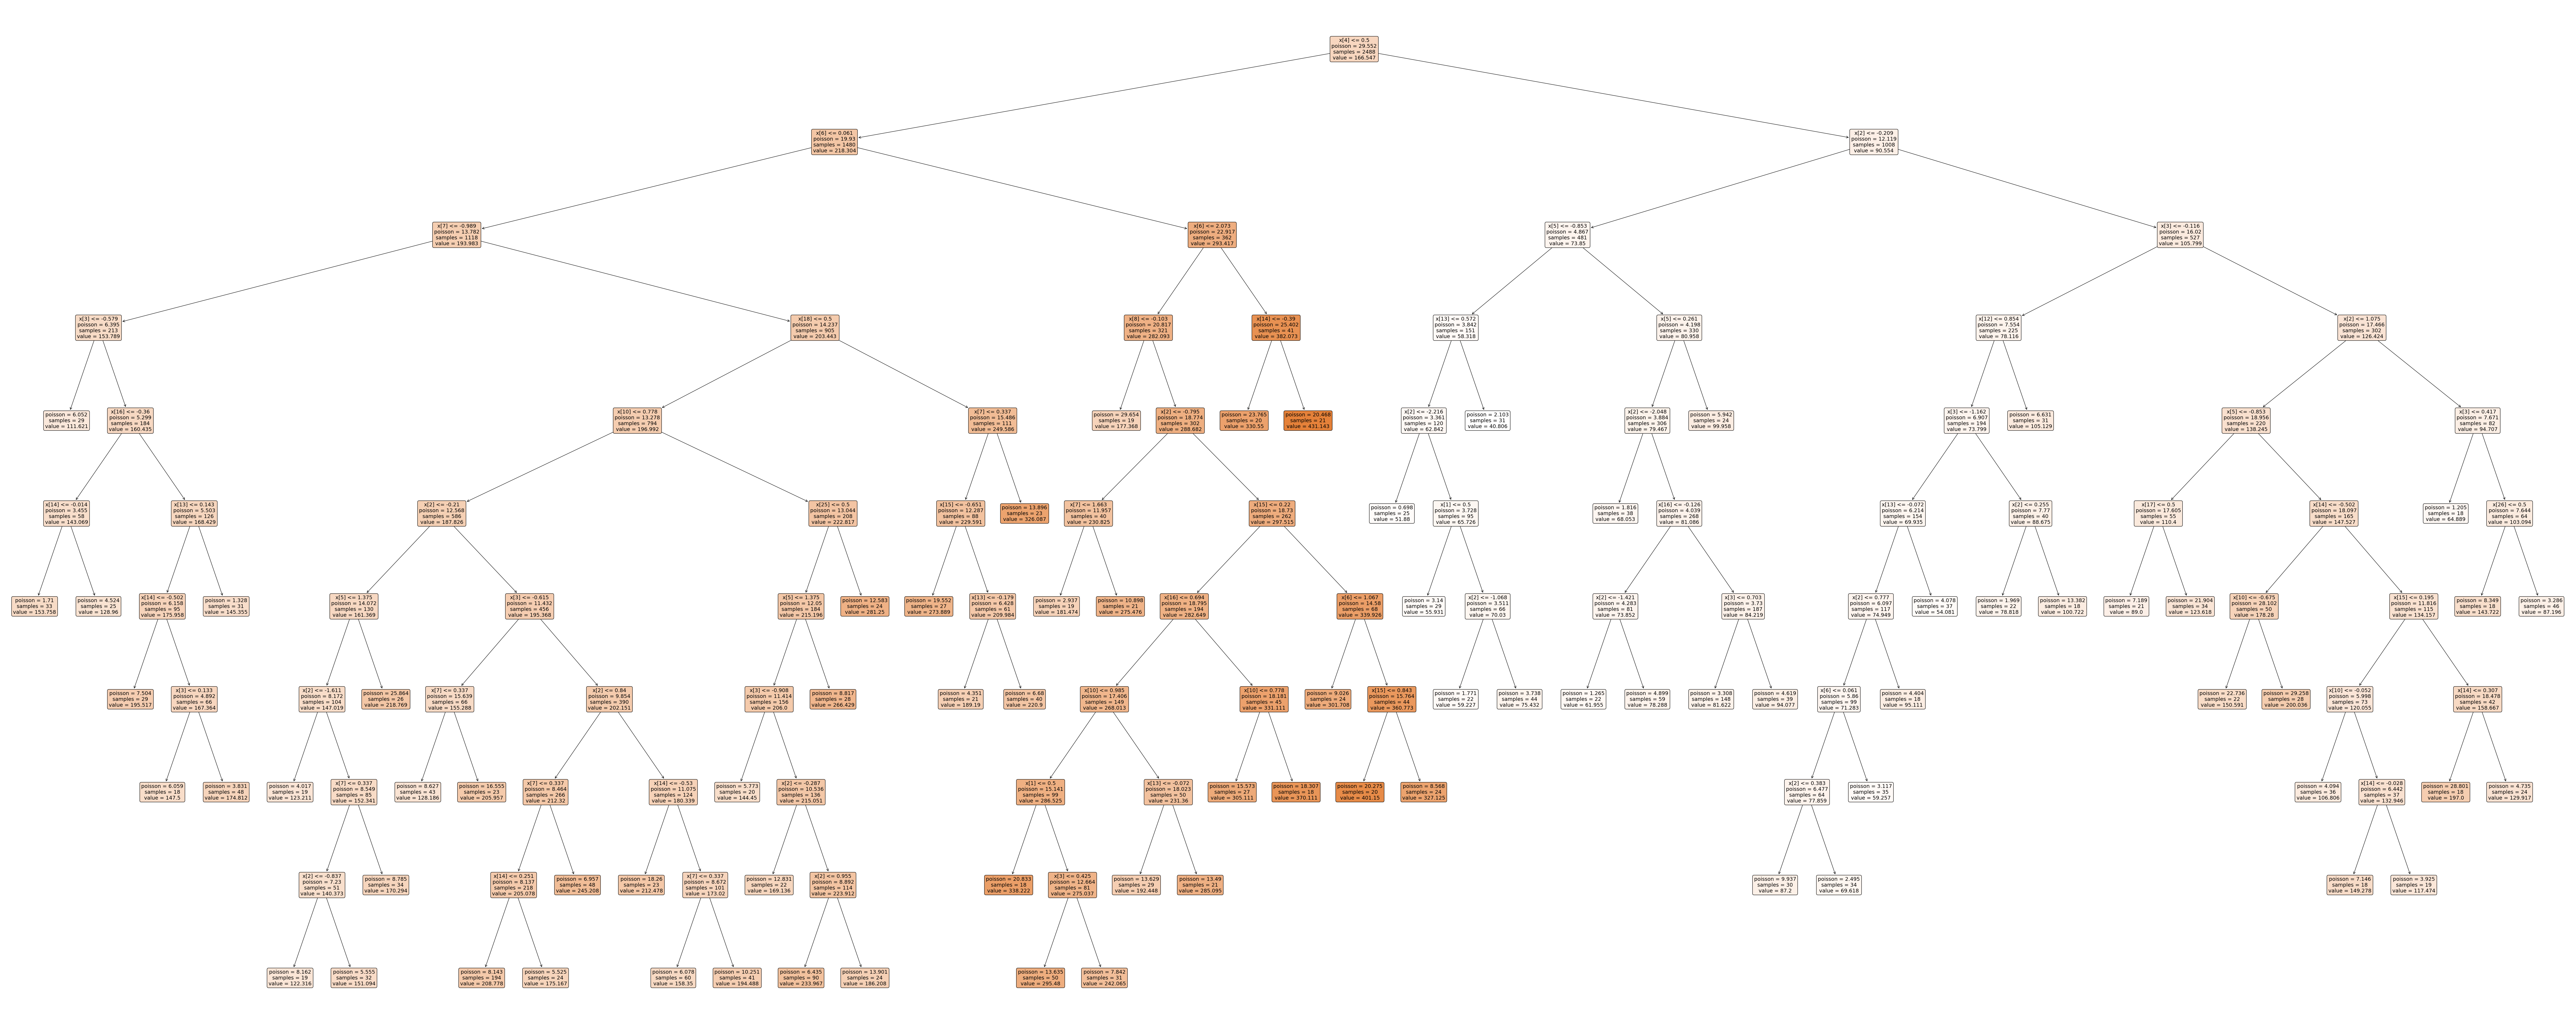

In [14]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(125,50))
tree = plot_tree(grid_search.best_estimator_, 
              #feature_names=train_inputs.columns.values, # our feature names are stripped from the data set
              class_names=['lt 150', 'gte 150'], 
              filled=True, 
              rounded=True, 
              fontsize=14)